In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

/tmp/ipykernel_6379/1056814220.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_6379/1056814220.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## data female

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_female = pd.concat([sample,sample2])
df_female.rename(columns={'binned_age': 'age'}, inplace=True)
df_female.set_index(['age', 'mouse'], inplace=True)

## data males

In [6]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

## normalized

In [7]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [8]:
## joint data
m_data=m_df.copy()
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data=f_df.copy()
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

In [9]:
format_plots()

In [10]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in f_data.groupby('age'):
    inter_ind_dists = pdist(_df, metric='jensenshannon')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df_f = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


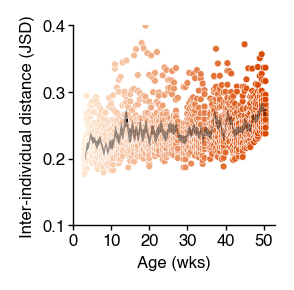

In [11]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)
sns.despine()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_female_JSD.pdf')

In [13]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in m_data.groupby('age'):
    inter_ind_dists = pdist(_df, metric='jensenshannon')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df_m = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


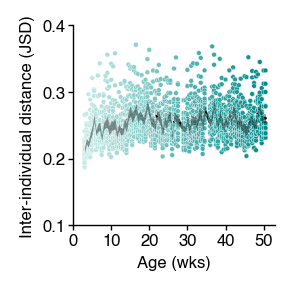

In [14]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))

a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_male_JSD.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

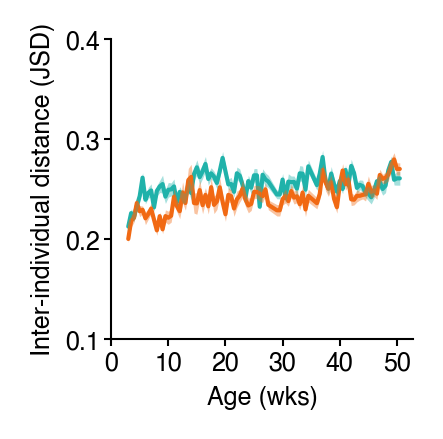

In [16]:
fig = figure(1.3, 1.3)
ax = fig.gca()
'''
a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
'''
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='#20B2AA',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)


a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='#f16913',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)

sns.despine()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_fvm_JSD.pdf')